In [1]:
#Let's start 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

C:\Users\Ricardo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

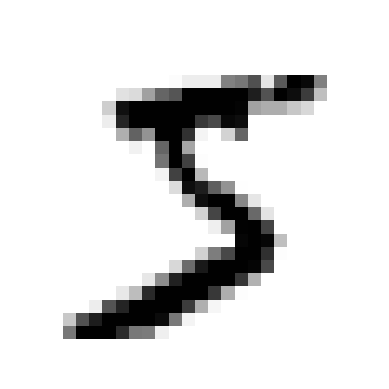

In [34]:
#I want to see how the first row looks like:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
some_digit = X.head(1)
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [40]:
#Splitting first 60k rows as train and the rest as test:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [61]:
#Creating a binary classifier:
y_train_5 = (y_train.astype('int') == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test.astype('int') == 5)

In [64]:
#Training a classifier with the data
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [67]:
sgd_clf.predict(some_digit)
#It guesses correctly

array([ True])

In [68]:
#I will cross validate the training set now:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [69]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [70]:
"I want to see the confussion matrix"
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [89]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [90]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [76]:
#Evaluating performance
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [78]:
#Let's plot the ROC curve to further analyze data
from sklearn.metrics import roc_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

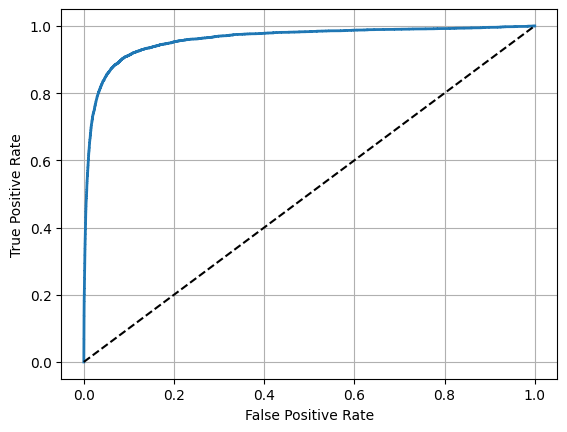

In [83]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

In [84]:
#Comparing area below the AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [85]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [86]:
y_scores_forest = y_probas_forest[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

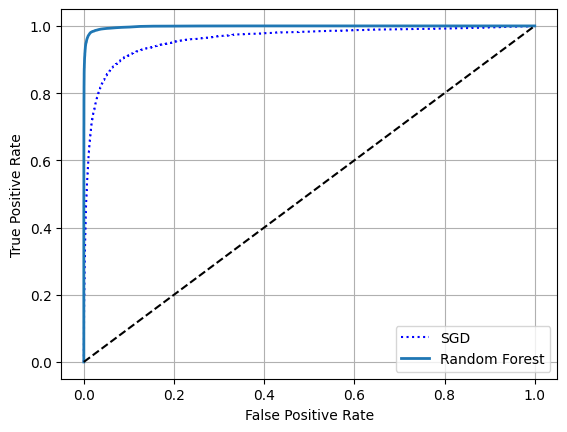

In [87]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [88]:
#Curve looks good, lets compare the area below the AUC
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [101]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [102]:
#A greater area below the AUC curve should represent a greater recall and precision compared to the first model
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [103]:
precision_score(y_train_5, y_train_pred_forest) #Way much better

0.9905083315756169

In [104]:
#Let's start multiclassifying classes with SVM:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) 
svm_clf.predict(some_digit)

array(['5'], dtype=object)

In [106]:
#Now, I want to see how it classifies the digit of the beginning:
some_digit_scores = svm_clf.decision_function(some_digit)
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [108]:
import numpy as np
svm_clf.classes_[np.argmax(some_digit_scores)] #It is a five indeed

'5'

In [115]:
#Finally, I will solve the multiclass problem by using SVM
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.977 , 0.9738, 0.9739])

In [117]:
#I think I might get a better accuracy by using K neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
grid_params = {
    'n_neighbors': [3,5,9],
    'weights': ['uniform', 'distance']
}

In [118]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(knn, grid_params, cv=3,
    scoring='accuracy',
    verbose = 1,
    return_train_score=True)

In [119]:
#I will scale the data before starting
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [120]:
#Let's start the grid search
grid_search_results = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [125]:
grid_search_results.best_score_ #Accuracy below SVM Levels

0.9420999999999999

In [135]:
#Finally, I will fit using SVM
svm_clf = SVC()
svm_clf.fit(X_train, y_train)  #Once more because I Scaled X_train
svm_pred = svm_clf.predict(X_test)

In [137]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, svm_pred) # Final Accuracy

0.966